In [1]:
import os
import sys
import datetime
import pprint
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import _init_paths
from config.default import cfg_from_list, cfg_from_file, update_config
from config.default import config as cfg
from core.engine import creat_data_loader, str_gpus, \
    AverageMeter, accuracy, list2acc, adjust_learning_rate_normal
from core.functions import prepare_env
from utils import mkdir, Logger
from cams import evaluate_cls_loc

import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torch.nn.functional as F

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

from models.vgg import vgg16_cam
from timm.models import create_model as create_deit_model
from timm.optim import create_optimizer
from urllib.request import urlretrieve

In [2]:
from torch import Tensor
from torchvision.transforms import functional as TF
class Normalize(torch.nn.Module):
    def __init__(self, mean, std, inplace=False):
        super().__init__()
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def forward(self, tensor: Tensor) -> Tensor:
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        tensor = tensor[[2,1,0]]
        tensor = tensor * 255.
        return TF.normalize(tensor, self.mean, self.std, self.inplace)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
config_file = '../configs/VOC//deit_cam_small_patch16_224.ymal'
cfg_from_file(config_file)
cfg.BASIC.ROOT_DIR = '../'

/home/ubuntu/Workspace/GaoWei/WSOL/TransLocPascal/tools_cam/../lib/config/default.py:124: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_config = AttrDict(yaml.load(fopen))


In [4]:
_ , val_loader = creat_data_loader(cfg, os.path.join(cfg.BASIC.ROOT_DIR, cfg.DATA.DATADIR))
dataset = val_loader.dataset

==> Preparing data...
done!


In [5]:
len(dataset)

4952

In [6]:
len(val_loader)

39

In [7]:
model = create_deit_model(
            cfg.MODEL.ARCH,
            pretrained=True,
            num_classes=cfg.DATA.NUM_CLASSES,
            drop_rate=0.0,
            drop_path_rate=0.1,
            drop_block_rate=None,
        )
model = model.cuda()

Removing key head.weight from pretrained checkpoint
Removing key head.bias from pretrained checkpoint


In [8]:
checkpoint = torch.load('../ckpt/PascalVoc/deit_cam_small_patch16_224_CAM-NORMAL_SEED26_CAM-THR0.1_BS64_2021-06-05-20-38/ckpt/model_epoch30.pth')

In [9]:
pretrained_dict = {k[7:]: v for k, v in checkpoint['state_dict'].items()}

In [10]:
model.load_state_dict(pretrained_dict)
model.eval()

TSCAM(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear

In [46]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [90]:
idx=4
img_dir = dataset.image_path_at(idx)
im = Image.open(img_dir).convert('RGB')
im_label = dataset._image_label[idx]
im_class = [dataset._classes[cls_id] for cls_id, cls in enumerate(im_label) if cls>0]
x = transform(im)
x.size()

torch.Size([3, 224, 224])

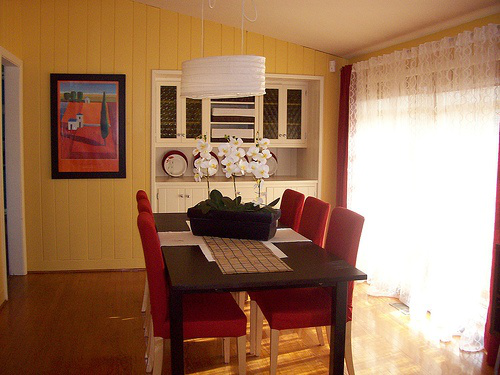

In [91]:
im

In [92]:
im_label

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0.], dtype=float32)

In [93]:
im_class

['chair', 'diningtable', 'pottedplant']

In [94]:
x_logits, cams = model(x.unsqueeze(0).cuda(), True)

In [95]:
cams.shape

torch.Size([1, 20, 14, 14])

In [101]:
x_probs = F.sigmoid(x_logits)

In [102]:
x_probs

tensor([[6.4248e-05, 9.7184e-06, 1.1239e-04, 1.1698e-04, 1.3139e-04, 1.1925e-05,
         7.2882e-05, 1.2599e-03, 1.0000e+00, 1.3776e-04, 2.1141e-02, 1.2984e-04,
         4.5436e-05, 1.4821e-04, 1.0230e-05, 5.2214e-03, 7.1713e-05, 5.1689e-01,
         1.8142e-05, 1.0730e-04]], device='cuda:0', grad_fn=<SigmoidBackward>)

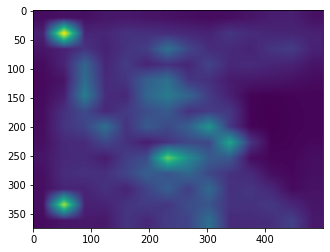

In [105]:
cams_0 = cams[0,15,:,:].detach().cpu().numpy()
mask = cv2.resize((cams_0) / (cams_0.max()), im.size)
plt.imshow(mask)

In [106]:
mask.min()

1.0029541

In [107]:
mask = cv2.resize(cams_0 / cams_0.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

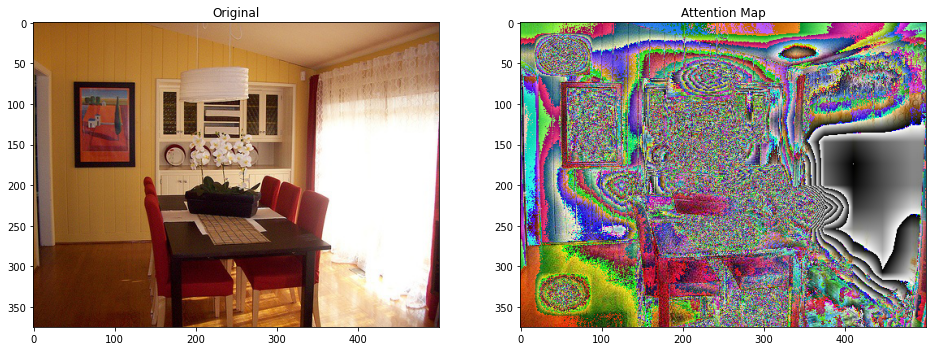

In [108]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

In [109]:
with torch.no_grad():
    x_patch, attn_weights = model.forward_features(x.unsqueeze(0).cuda())
    n, p, c = x_patch.shape
    x_patch = torch.reshape(x_patch, [n, int(p**0.5), int(p**0.5), c])
    x_patch = x_patch.permute([0, 3, 1, 2])
    x_patch = x_patch.contiguous()
    x_logits = model.head(x_patch)
    
    attn_weights = torch.stack(attn_weights)
    attn_weights = torch.mean(attn_weights, dim=2)
    residual_att = torch.eye(attn_weights.size(2)).unsqueeze(0).unsqueeze(1).to(attn_weights.get_device())    # 12 * B * N * N
    aug_att_mat = attn_weights + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    joint_attns = torch.zeros(attn_weights.size()).to(attn_weights.get_device())
    joint_attns[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size()[0]):
        joint_attns[n] = torch.matmul(aug_att_mat[n], joint_attns[n-1])
    feature_map = x_logits.detach().clone()
    b, c, h, w = feature_map.shape
    cams_re = joint_attns[-1][:, 0, 1:].reshape([b, h, w]).unsqueeze(1)       # B * 1* h * w
    cams_re = cams_re * feature_map

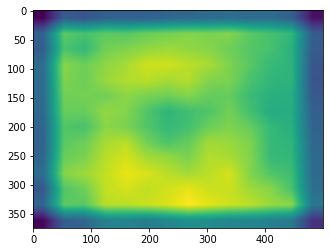

In [111]:
feat_cls = feature_map[0, 8, :,:].detach().cpu().numpy()
attn=cv2.resize(feat_cls, im.size)
plt.imshow(attn)

In [112]:
attn_weights.shape

torch.Size([12, 1, 197, 197])

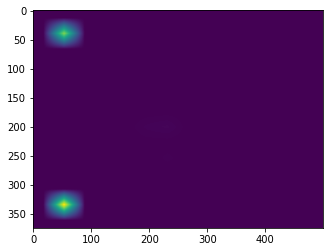

In [114]:
attn = attn_weights[-1,0][0,1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

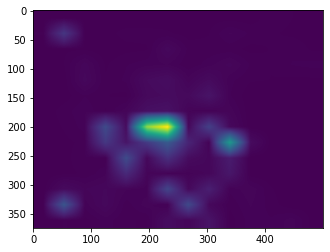

In [119]:
attn = attn_weights[-2,0, 1:].sum(0)[1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

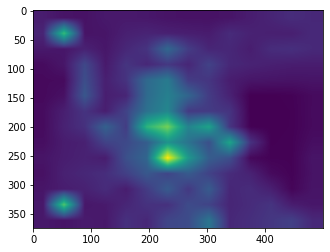

In [117]:
attn = attn_weights.sum(0)[0, 0][1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

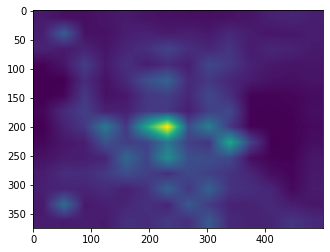

In [118]:
attn = attn_weights.sum(0)[0, 1:].sum(0)[1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

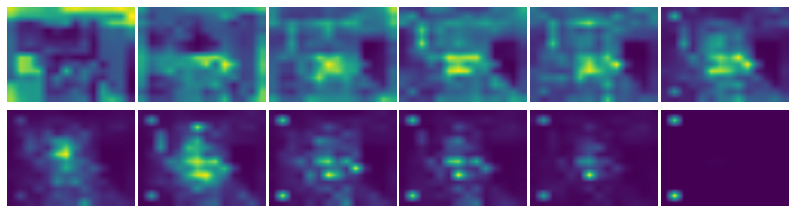

In [120]:
left = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.45     # the top of the subplots of the figure
wspace = 0.05  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.05  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(14, 3.8))
#fig.tight_layout()
for row in range(2):
    for col in range(0,6):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn_l = attn_weights[row*6+col,0][0,1:].reshape(14, 14).detach().cpu().numpy()
        attn_l=cv2.resize(attn_l, im.size)
        axes[row][col].imshow(attn_l)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.025, hspace=0.001)
plt.show()

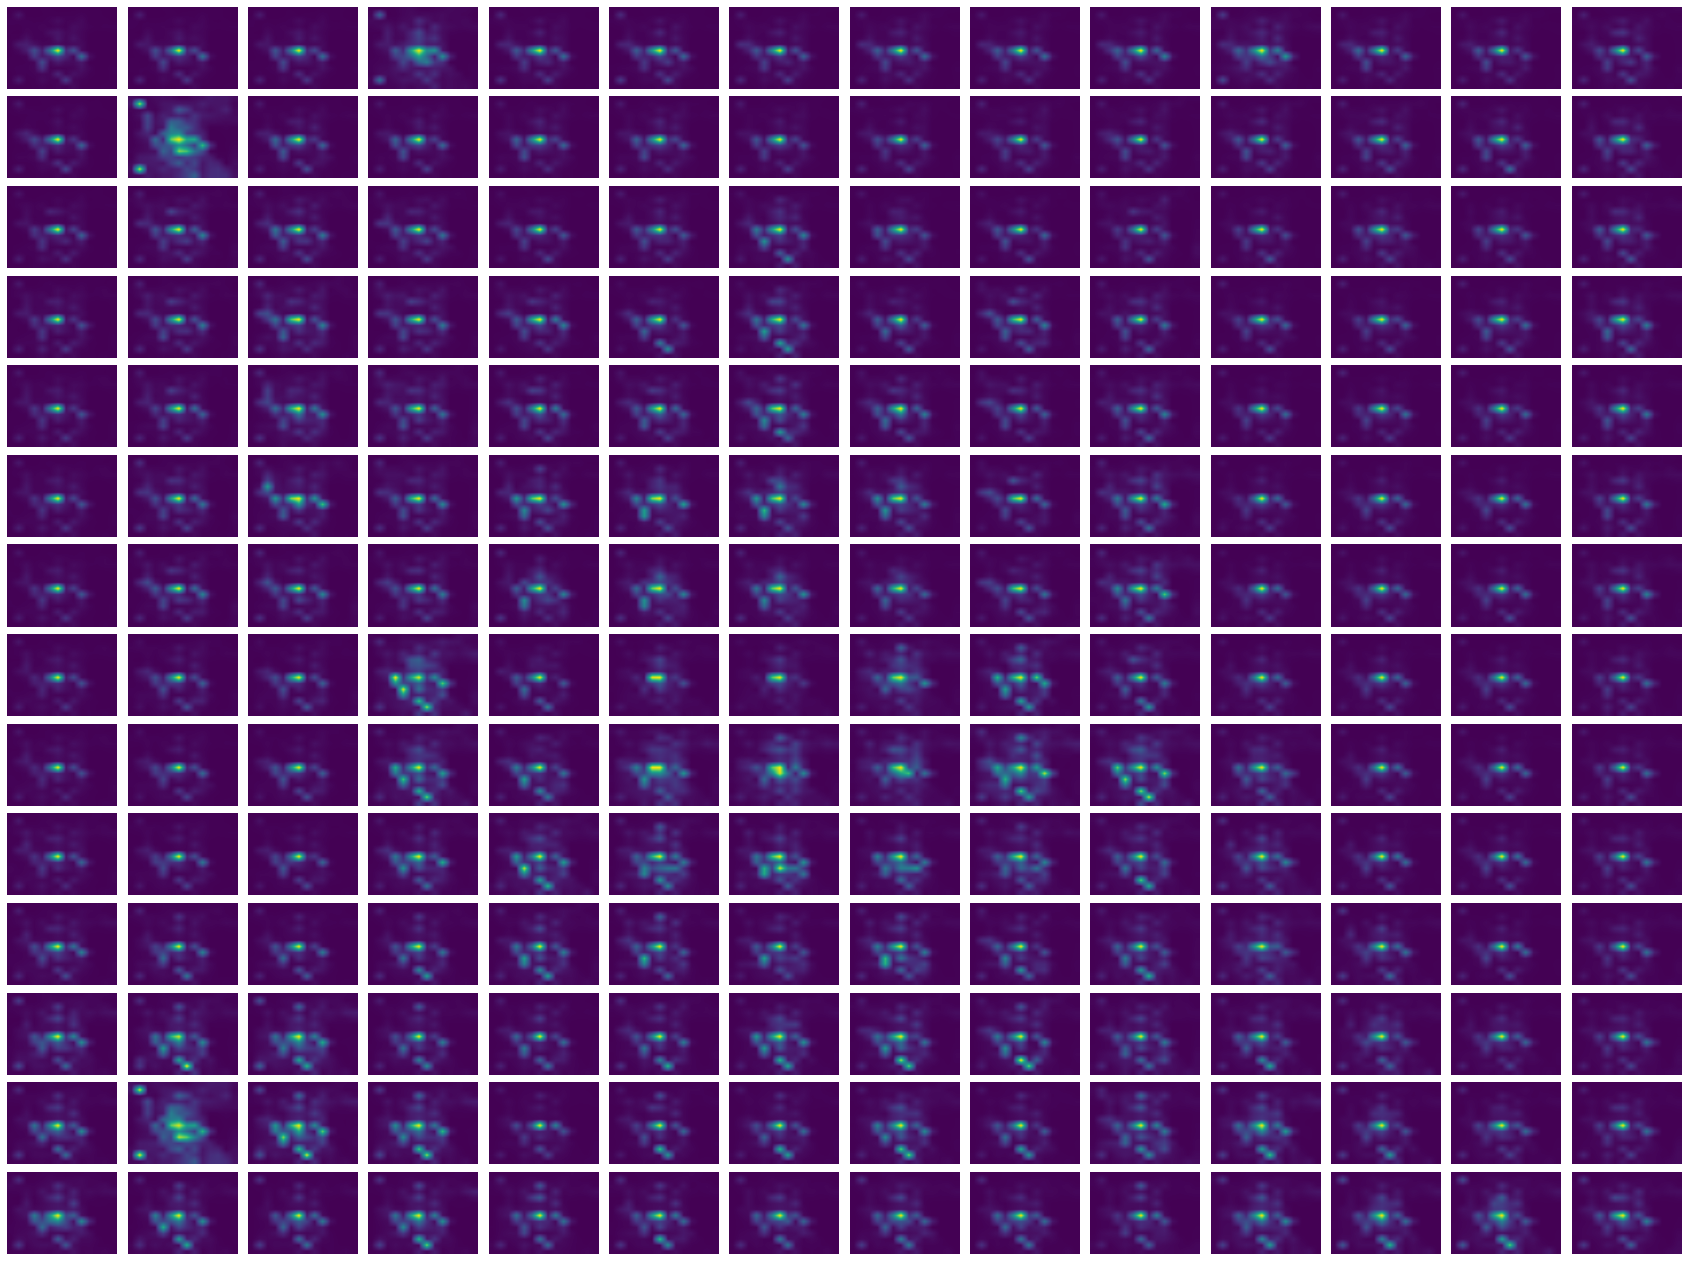

In [123]:
left = 0.0  # the left side of the subplots of the figure
right = 0.0   # the right side of the subplots of the figure
bottom = 0.0  # the bottom of the subplots of the figure
top = 0.0     # the top of the subplots of the figure
wspace = 0.1  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.005  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 23))
for row in range(14):
    for col in range(0,14):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn = attn_weights[-3,0][1:][row*14+col,1:].reshape(14, 14).detach().cpu().numpy()
        attn=cv2.resize(attn, im.size)
        axes[row][col].imshow(attn)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
#fig.tight_layout(pad=0.1)
plt.show()

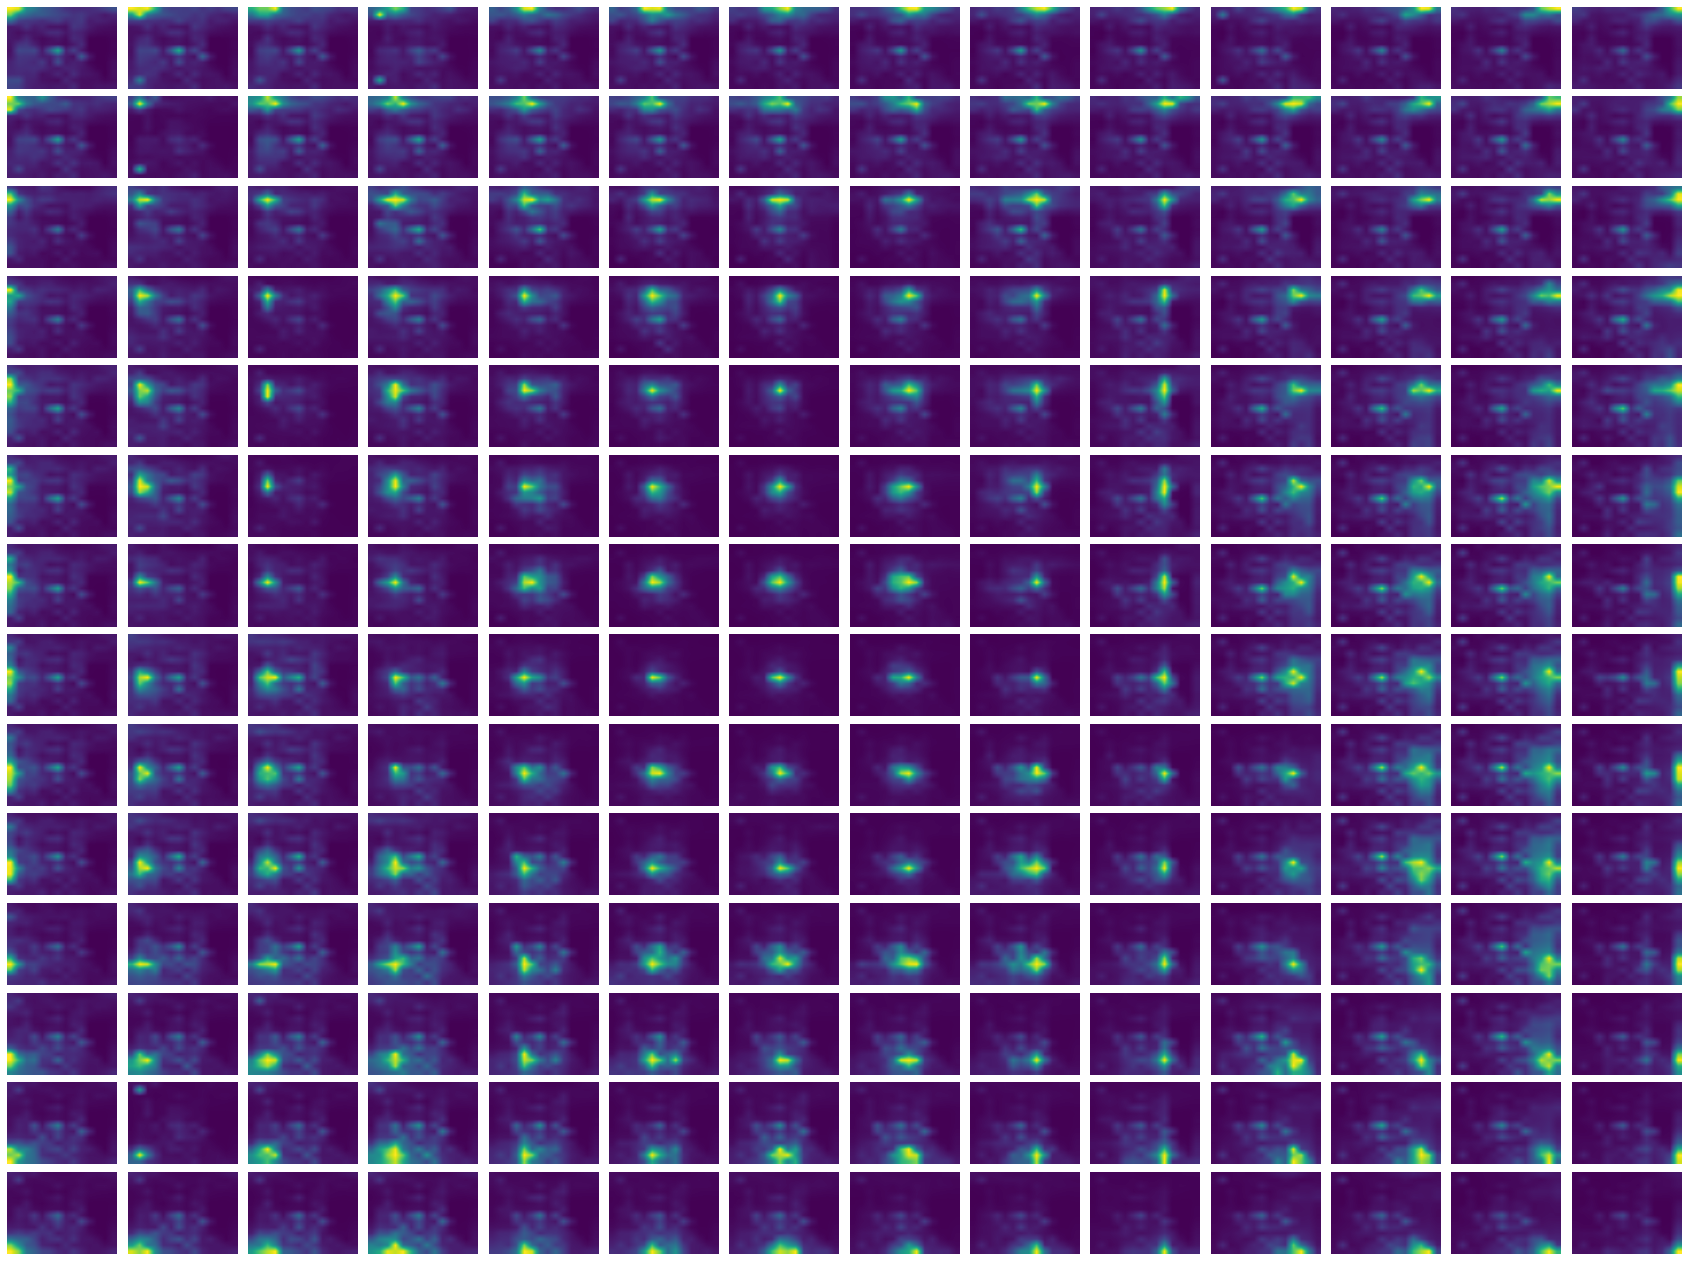

In [124]:
left = 0.0  # the left side of the subplots of the figure
right = 0.0   # the right side of the subplots of the figure
bottom = 0.0  # the bottom of the subplots of the figure
top = 0.0     # the top of the subplots of the figure
wspace = 0.1  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.005  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 23))
for row in range(14):
    for col in range(0,14):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn = attn_weights[:-1].mean(0)[0][1:][row*14+col,1:].reshape(14, 14).detach().cpu().numpy()
        attn=cv2.resize(attn, im.size)
        axes[row][col].imshow(attn)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
#fig.tight_layout(pad=0.1)
plt.show()

(-0.5, 499.5, 374.5, -0.5)

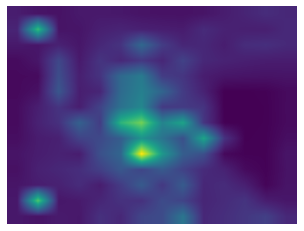

In [125]:
mask_attn = attn_weights.mean(0)[0, 0][1:].reshape(14, 14).detach().cpu().numpy()
mask_attn=cv2.resize(mask_attn, im.size)
#plt.imshow(attn, cmap='gray')
plt.imshow(mask_attn)
plt.axis('off')

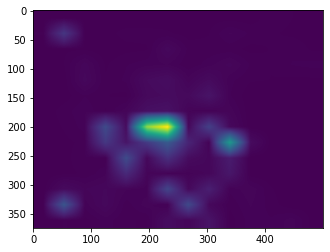

In [126]:
attn = attn_weights[-2,0, 1:].sum(0)[1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

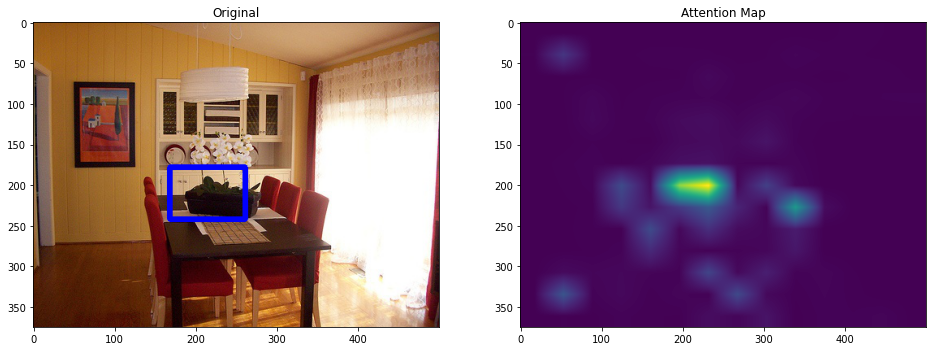

In [127]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)
_, mask_re_gray_heatmap = cv2.threshold(attn,
                                        attn.max()*0.2, 1,
                                        cv2.THRESH_TOZERO)
contours, _ = cv2.findContours((mask_re_gray_heatmap*255).astype(np.uint8),
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
w,h=im.size
if len(contours) != 0:
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    estimated_bbox = [x, y, x + w, y + h]
    color1=(0, 0, 255)
heatmap = cv2.applyColorMap((attn*255).astype(np.uint8), cv2.COLORMAP_TURBO)
blend = np.array(im) * 0.5 + heatmap * 0.5
im_box = cv2.rectangle(np.array(im), (estimated_bbox[0], estimated_bbox[1]), (estimated_bbox[2], estimated_bbox[3]), color1, 6)
_ = ax1.imshow(im_box)
_ = ax2.imshow(attn)

In [128]:
v = joint_attns[-1,0,-1,1:].reshape([int(p**0.5), int(p**0.5)]).cpu().numpy()
mask_v = cv2.resize(v / v.max(), im.size)
im_mask_v = (mask_v[...,np.newaxis] * im).astype("uint8")

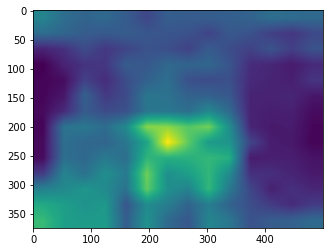

In [129]:
plt.imshow(mask_v)

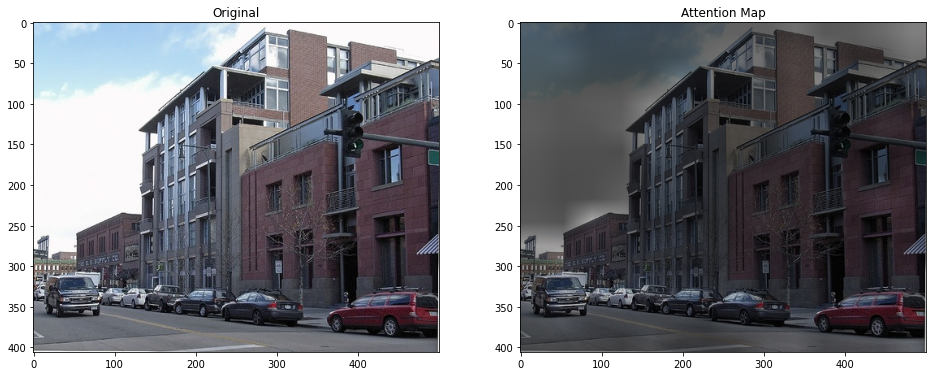

In [85]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(im_mask_v)

In [86]:
v_re = cam_remap[0,:,:, 0].reshape([int(p**0.5), int(p**0.5)]).cpu().numpy()
mask_v_re = cv2.resize(v_re / v_re.max(), (224,224))
im_resize = cv2.resize(np.array(im), (224,224))
im_mask_v_re = (mask_v_re[...,np.newaxis] * im_resize).astype("uint8")

NameError: name 'cam_remap' is not defined

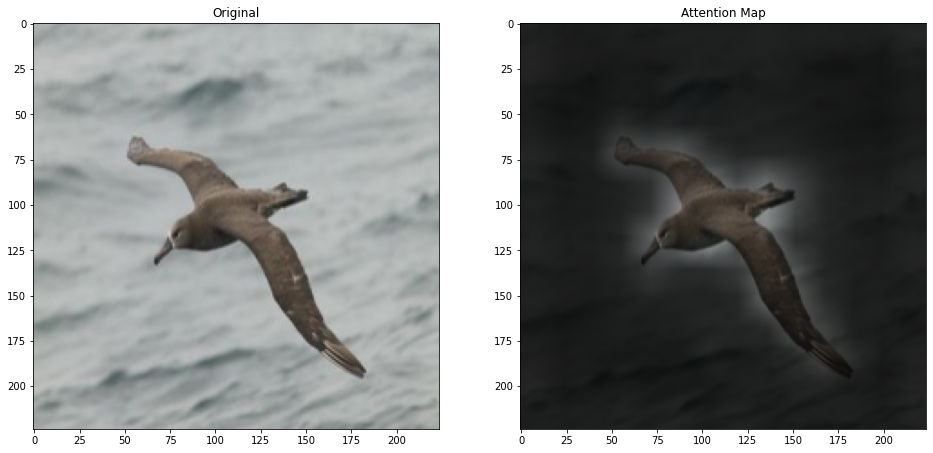

In [553]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im_resize)
_ = ax2.imshow(im_mask_v_re)

In [541]:
mask_v_re.max()

0.997629

In [542]:
mask_v.min()

0.112720296

In [554]:
_, mask_re_gray_heatmap = cv2.threshold(mask_v_re,
                                        mask_v_re.max()*0.3, 1,
                                        cv2.THRESH_TOZERO)
contours, _ = cv2.findContours((mask_re_gray_heatmap*255).astype(np.uint8),
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
if len(contours) != 0:
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    estimated_bbox = [x, y, x + w, y + h]
color1=(255, 0, 0)
heatmap = cv2.applyColorMap((mask_re_gray_heatmap*255).astype(np.uint8), cv2.COLORMAP_JET)
im_box = cv2.rectangle(im_resize, (estimated_bbox[0], estimated_bbox[1]), (estimated_bbox[2], estimated_bbox[3]), color1, 2)

In [561]:
estimated_bbox

[48, 60, 178, 192]

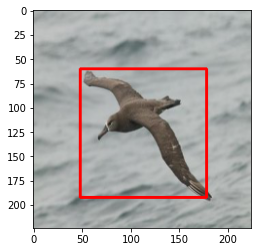

In [555]:
plt.imshow(im_box)

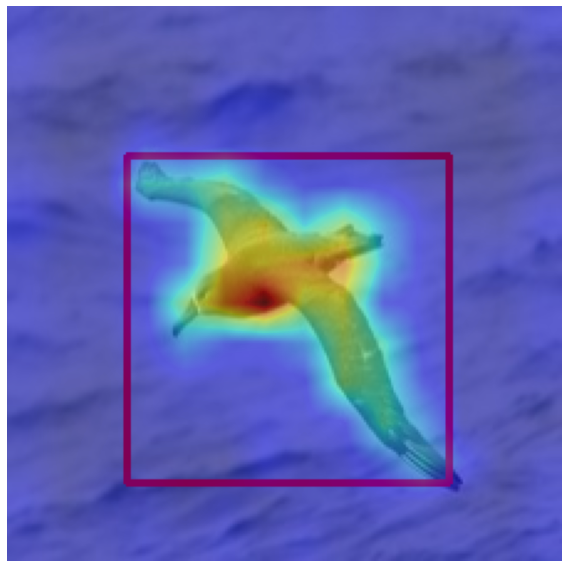

In [557]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im_box, aspect='equal', cmap=plt.cm.rainbow)
ax.imshow(mask_v_re, aspect='equal', cmap=plt.cm.jet, alpha = 0.5)
#ax.scatter(inds[1][-222:],inds[0][-222:], 60, '#FA0026', '*')
box = np.array([40.270714,   0.,       279.72928,  346.1252])
'''
ax.add_patch(
            plt.Rectangle((box[0], box[1]),
                          box[2] - box[0],
                          box[3] - box[1], fill=False,
                          edgecolor='g', linewidth=12, zorder=2)
            )
'''
#ax.contourf(basefeat_np_img_up, 15, cmap=plt.cm.rainbow)
plt.axis('off')
plt.tight_layout()
plt.draw()

In [546]:
v_aug = aug_att_mat[-1,0,-1,1:].reshape([int(p**0.5), int(p**0.5)]).cpu().numpy()
mask_v_aug = cv2.resize(v_aug / v_aug.max(), im.size)
im_mask_v_aug = (mask_v_aug[...,np.newaxis] * im).astype("uint8")

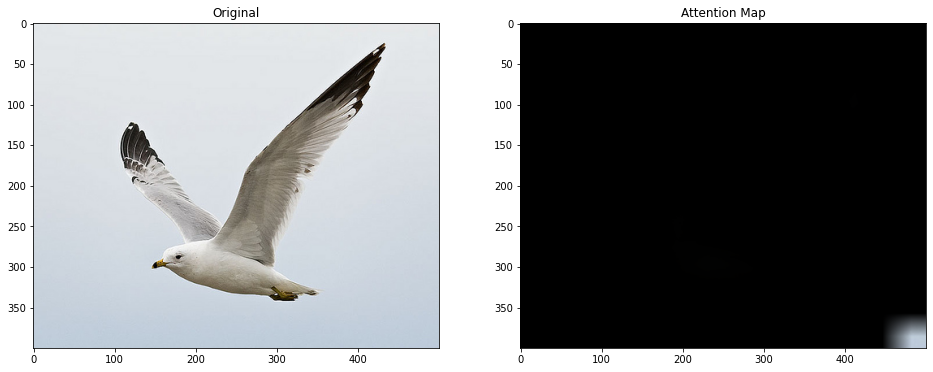

In [114]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(im_mask_v_aug)

In [69]:
x_patch_feature_ma = x_patch.detach().cpu().numpy()[0,1:].reshape([14,14,-1])

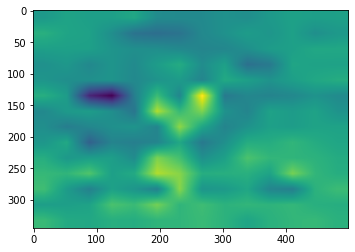

In [72]:
plt.imshow(cv2.resize(x_patch_feature_ma[:,:,10], im.size))

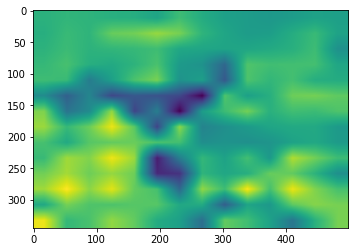

In [73]:
plt.imshow(cv2.resize(x_patch_feature_ma.max(axis=-1), im.size))

In [109]:
# Test Image
img_url = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg"
urlretrieve(img_url, "../attention_data/img.jpg")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open("../attention_data/img.jpg")
x = transform(im)
x.size()

torch.Size([3, 224, 224])

In [81]:
x_logits, cams = model(x.unsqueeze(0).cuda(), True)

In [82]:
x_logits.argmax()

tensor(0, device='cuda:0')

In [83]:
im.size

(960, 642)

In [84]:
cams_0 = cams[0,0,:,:].detach().cpu().numpy()
mask = cv2.resize(cams_0 / cams_0.max(), im.size)

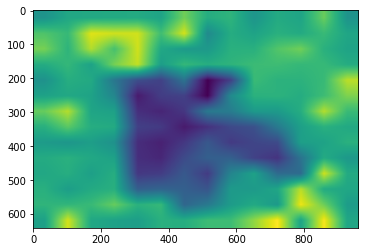

In [85]:
plt.imshow(mask)

In [86]:
cams_0 = cams[0,0,:,:].detach().cpu().numpy()
mask = cv2.resize(cams_0 / cams_0.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

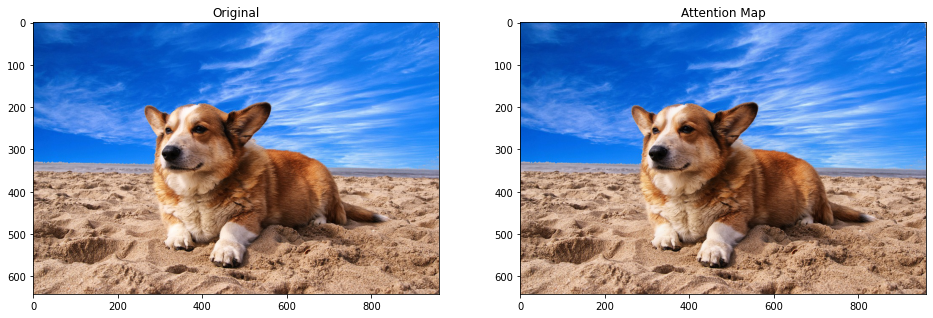

In [87]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)